In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.dummy
import sklearn.metrics
import sklearn.neural_network
import sklearn.ensemble
from joblib import dump
import seaborn as sns
import scipy
sns.set()

Fetch the data frames from the files

In [3]:
# read both the matches and the frames
trn_df = pd.read_csv('../data/processed/diff_trn.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
tst_df = pd.read_csv('../data/processed/diff_tst.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
# Reinterpret all values as int32s
trn_df = trn_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})

tst_df = tst_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})

Helper functions to format the data prior to training

In [32]:
random_state = 0
np.random.seed(random_state)
dpi = 300

def corr_filter(n):
    """ Filters the set of features based on minimum correlation n"""
    all_features = list(tuple(zip(trn_df.corr()['winner'].drop(['winner']).index.to_list(),
          trn_df.corr()['winner'].drop(['winner']).to_list())))
    drop = [i[0] for i in all_features if i[1] < n]
    trn_df.drop(columns=drop, inplace=True)
    tst_df.drop(columns=drop, inplace=True)
    
def plot_data(X, y):
    return
    """Plots the data."""
    plt.scatter(*X[y==-1].T, marker="x", c="r")
    plt.scatter(*X[y==1].T, marker="x", c="b")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.gca().set_aspect('equal')
    plt.grid(False)

def plot_decision_function(model):
    return
    """
    Plots the decision function of a model as a red-blue heatmap.
    The region evaluated, along with x and y axis limits, are determined by 'extent'.
    """
    extent = (0 , 1, 0, 1)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 200), np.linspace(x2min, x2max, 200))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.decision_function(X).reshape(x1.shape)
    plt.imshow(-y, extent=extent, origin='lower', vmin=-1, vmax=1, cmap='bwr', alpha=0.5, interpolation='nearest')
    if y.min() < 0 and y.max() > 0:
        plt.contour(x1, x2, y, levels=[0], colors=['k'])  # Decision boundary
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    plt.grid(False)
    
def plot_rf_prediction(model):
    """
    Plots the model's predictions over all points in range 2D [-3, 3].
    Assumes at most 3 classes.
    """
    return
    extent = (0, 1, 0, 1)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.predict(X).reshape(x1.shape)
    cmap = matplotlib.colors.ListedColormap(['r', 'b', 'g'])
    plt.imshow(y, extent=extent, origin='lower', alpha=0.4, vmin=0, vmax=2, cmap=cmap, interpolation='nearest')
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    plt.gca().set_aspect('equal')
    plt.grid(False)

def scale_data(X_trn, X_tst):
    """
    Scales the data with Scikit-learn's MinMax scaler.
    """
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)

    return X_trn, X_tst

def score_estimators(X, y, estimators):
    """
    Scores each estimator on (X, y), returning a list of scores.
    """
    scores = [0 for _ in range(len(estimators))]
    for x in range(len(estimators)):
        scores[x] = sklearn.metrics.accuracy_score(y, estimators[x].predict(X))
        print(sklearn.metrics.precision_recall_fscore_support(y, estimators[x].predict(X), average='binary'))
    return scores

def plot_estimator_scores(estimators, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    plt.figure(dpi=dpi)
    X = np.arange(0, len(param_vals))
    trn_scores = score_estimators(X_trn, y_trn, estimators)
    tst_scores = score_estimators(X_tst, y_tst, estimators)
    index = np.argmin(trn_scores - tst_scores)
    print(tst_scores[index])
    plt.title(estimators[0].__class__.__name__ + " score vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.ylim(0.0, 1.05)
    plt.scatter(X[index], tst_scores[index], marker='x', color='black', s=200)
    plt.plot(X, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    plt.plot(X, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    plt.text(0, 0.4,
             "Optimal Test Accuracy = %.2f%% with %s = %d " % (tst_scores[index] * 100, param_name, param_vals[index]))
    plt.legend()
    plt.xticks(X, param_vals)
    plt.grid(False)
    

def rand_param_search(X, y, estimator, param_grid, verbose=1, cv=5, n_iter=10, n_jobs=None):
    return sklearn.model_selection.RandomizedSearchCV(estimator, param_grid,verbose=verbose,
                                        cv=cv, n_iter=n_iter, n_jobs=n_jobs).fit(X, y)

def grid_param_search(X, y, estimator, param_grid, verbose=1, cv=5, n_jobs=None):
    return sklearn.model_selection.GridSearchCV(estimator, param_grid, verbose=verbose,
                                        cv=cv, n_jobs=n_jobs).fit(X, y)

Feature selection: Select an X and y we want to train on

In [90]:
# Randomly select data points for plots
corr_filter(0.5)
indices = np.random.choice(trn_df.shape[0], 200, replace=False)
X_trn = trn_df.drop(columns=['winner']).values
y_trn = trn_df[['winner']].values.T[0]
X_tst = tst_df.drop(columns=['winner']).values
y_tst = tst_df[['winner']].values.T[0]


In [91]:
"""
Scales the data with Scikit-learn's MinMax scaler.
"""
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_trn)
X_trn = scaler.transform(X_trn)
X_tst = scaler.transform(X_tst)


## Models

### AdaBoost

In [65]:
ab = sklearn.ensemble.AdaBoostClassifier(random_state=random_state)
param_grid = {
    'n_estimators' : [i for i in scipy.stats.uniform(1, 1000).rvs(10).astype('int32')],
    'algorithm' : ['SAMME', 'SAMME.R'] 
}
ab = rand_param_search(X_trn, y_trn, ab, param_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [66]:
plot_data(X_trn[indices], y_trn[indices])
plot_rf_prediction(ab.best_estimator_)

### Logistic Regression

In [67]:
lr = sklearn.linear_model.LogisticRegression(random_state=random_state, max_iter=10000)
param_grid = {
    'C': [i for i in scipy.stats.reciprocal(1e-05, 10).rvs(10)]
}
lr = rand_param_search(X_trn, y_trn, lr, param_grid, n_jobs=-1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [68]:
plot_data(X_trn[indices], y_trn[indices])
plot_rf_prediction(lr.best_estimator_)

### SVM

In [69]:
svm = sklearn.svm.SVC(random_state=random_state)
param_grid = {
    'C': [i for i in scipy.stats.reciprocal(0.01, 1000).rvs(10)],
    'gamma' : [i for i in scipy.stats.reciprocal(1, 1000).rvs(10)]
}
svm = rand_param_search(X_trn, y_trn, svm, param_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [70]:
plot_data(X_trn[indices], y_trn[indices])
plot_rf_prediction(svm.best_estimator_)
plot_decision_function(svm)

## Dummy Classifier

In [71]:
dummy = sklearn.dummy.DummyClassifier(strategy='uniform', random_state=0)
dummy.fit(X_trn, y_trn)

DummyClassifier(random_state=0, strategy='uniform')

In [72]:
plot_data(X_trn[indices], y_trn[indices])
plot_rf_prediction(dummy)

## kNN 

In [73]:
param_grid = {
    'n_neighbors': [1, 5, 10, 15, 20]
}
knn = sklearn.neighbors.KNeighborsClassifier()
knn = grid_param_search(X_trn, y_trn, estimator=knn, param_grid=param_grid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [74]:
plot_data(X_trn[indices], y_trn[indices])
plot_rf_prediction(knn.best_estimator_)

## Random Forests

In [75]:

param_grid = {
    'n_estimators': np.arange(1, 5) * 50, 
    'max_depth': np.arange(1, 5) * 5
}
rf = sklearn.ensemble.RandomForestClassifier(random_state=0)
rf = grid_param_search(X_trn, y_trn, estimator=rf, param_grid=param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [76]:
plot_data(X_trn[indices], y_trn[indices])
plot_rf_prediction(rf.best_estimator_)

## Neural Network

In [77]:
net = sklearn.neural_network.MLPClassifier(        
    learning_rate_init=0.01,
    activation='logistic',
    hidden_layer_sizes=(2,),
    momentum=0.9,
    solver='sgd',
    random_state=0,
)
param_grid = [
    {
        'max_iter': [5, 10, 50, 100, 150, 200]
    }
]
net = grid_param_search(X_trn, y_trn, estimator=net, param_grid=param_grid)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/b_lofo/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/b_lofo/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/b_lofo/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/b_lofo/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.wa

In [78]:
plot_data(X_trn[indices], y_trn[indices])
plot_rf_prediction(net.best_estimator_)

## Evaluation

Plotting each prediction

## Validation Scores

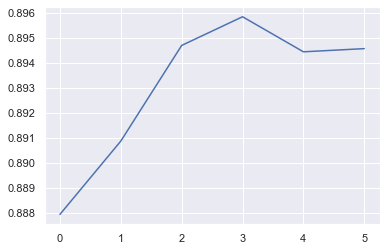

In [79]:
plt.plot(net.cv_results_['mean_test_score'])

## Final Scores from best estimators

In [84]:
for estimator in [knn, rf, ab, lr, svm, net]:
    y_pred = estimator.predict(X_tst)
    stats = sklearn.metrics.precision_recall_fscore_support(y_tst, y_pred, average='binary')
    print("Scores for %s:" % estimator.best_estimator_.__class__.__name__)
    print("Accuracy: %s" % sklearn.metrics.accuracy_score(y_tst, y_pred))
    print("Precision: %s" % stats[0])
    print("Recall: %s" % stats[1])


Scores for KNeighborsClassifier:
Accuracy: 0.9035714285714286
Precision: 0.8961364776718515
Recall: 0.912621359223301
Scores for RandomForestClassifier:
Accuracy: 0.9048469387755103
Precision: 0.8971915747241725
Recall: 0.9141543178334185
Scores for AdaBoostClassifier:
Accuracy: 0.9012755102040816
Precision: 0.8940763052208835
Recall: 0.9100664282064385
Scores for LogisticRegression:
Accuracy: 0.9028061224489796
Precision: 0.8987854251012146
Recall: 0.9075114971895759
Scores for SVC:
Accuracy: 0.9040816326530612
Precision: 0.8970366649924661
Recall: 0.912621359223301
Scores for MLPClassifier:
Accuracy: 0.9022959183673469
Precision: 0.8935
Recall: 0.9131323454266734


## Misclassifications

In [99]:

misclassified, = np.nonzero(np.logical_and(y_tst==1, y_pred==-1))
pd.DataFrame(data=scaler.inverse_transform(X_tst[misclassified]), columns=trn_df.drop(columns=['winner']).columns).head(n=10)

,first_inhibitor,first_baron,kill_advantage,gold_advantage,damage_advantage,tower_advantage
0,-1.0,1.0,4.0,-2391.0,-15982.0,-5.0
1,-1.0,1.0,6.0,-1637.0,-3938.0,-1.0
2,-1.0,-1.0,7.0,5682.0,15075.0,3.0
3,-1.0,1.0,5.0,1811.0,13800.0,1.0
4,-1.0,-1.0,-15.0,-1472.0,-12730.0,-4.0
5,-1.0,1.0,0.0,-5792.0,-16715.0,-2.0
6,-1.0,-1.0,6.0,-1331.0,1437.0,0.0
7,-1.0,-1.0,5.0,-1545.0,-1523.0,-3.0
8,-1.0,-1.0,-7.0,-3439.0,-4507.0,-4.0
9,-1.0,-1.0,3.0,1807.0,466.0,3.0


In [81]:
# Dump each models for the TAs to try them out
dump(dummy, 'dm_clf.joblib')
dump(lr.best_estimator_, 'logistic_clf.joblib')
dump(ab.best_estimator_, 'boost_clf.joblib')
dump(svm.best_estimator_, 'svm_clf.joblib')
dump(net.best_estimator_, 'nn_clf.joblib')
dump(knn.best_estimator_, 'knn_clf.joblib')
dump(rf.best_estimator_, 'rf_clf.joblib')

['rf_clf.joblib']